# XGBoost model

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

%matplotlib inline

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [3]:
data_dir = 'data'

In [4]:
prefix = 'vehicles-xgboost'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [20]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                    sagemaker_session=sagemaker_session)

	get_image_uri(region, 'xgboost', '0.90-1').


In [21]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [22]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb,
                                               objective_metric_name = 'validation:rmse',
                                               objective_type = 'Minimize',
                                               max_jobs = 20,
                                               max_parallel_jobs = 3,
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [23]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [ ]:
xgb_hyperparameter_tuner.wait()

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [29]:
xgb_hyperparameter_tuner.best_training_job()

'xgboost-200324-0910-020-642fc3ca'

In [30]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2020-03-24 10:07:24 Starting - Preparing the instances for training
2020-03-24 10:07:24 Downloading - Downloading input data
2020-03-24 10:07:24 Training - Training image download completed. Training in progress.
2020-03-24 10:07:24 Uploading - Uploading generated training model
2020-03-24 10:07:24 Completed - Training job completedArguments: train
[2020-03-24:10:01:13:INFO] Running standalone xgboost training.
[2020-03-24:10:01:13:INFO] Setting up HPO optimized metric to be : rmse
[2020-03-24:10:01:13:INFO] File size need to be processed in the node: 139.23mb. Available memory size in the node: 8515.55mb
[2020-03-24:10:01:13:INFO] Determined delimiter of CSV input is ','
[10:01:13] S3DistributionType set as FullyReplicated
[10:01:14] 213944x293 matrix with 62685592 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-03-24:10:01:14:INFO] Determined delimiter of CSV input is ','
[10:01:14] S3DistributionType set as FullyReplicated
[10:01:14] 25918x29

In [31]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [32]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

xgb_transformer.wait()

....................Arguments: serve
[2020-03-24 10:14:59 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-03-24 10:14:59 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-03-24 10:14:59 +0000] [1] [INFO] Using worker: gevent
[2020-03-24 10:14:59 +0000] [37] [INFO] Booting worker with pid: 37
[2020-03-24 10:14:59 +0000] [38] [INFO] Booting worker with pid: 38
[2020-03-24 10:14:59 +0000] [39] [INFO] Booting worker with pid: 39
[2020-03-24:10:14:59:INFO] Model loaded successfully for worker : 37
[2020-03-24:10:14:59:INFO] Model loaded successfully for worker : 38
[2020-03-24 10:14:59 +0000] [40] [INFO] Booting worker with pid: 40
[2020-03-24:10:14:59:INFO] Model loaded successfully for worker : 39
[2020-03-24:10:14:59:INFO] Model loaded successfully for worker : 40

[2020-03-24:10:15:19:INFO] Sniff delimiter as ','
[2020-03-24:10:15:19:INFO] Determined delimiter of CSV input is ','
[2020-03-24:10:15:19:INFO] Sniff delimiter as ','
[2020-03-24:10:15:19:INFO] Determined delimit

In [33]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-ap-southeast-1-364665614436/xgboost-200324-0910-020-642fc3ca-2020-03-24-10-11-55-836/test.csv.out to data/test.csv.out


In [34]:
y_test = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), header=None)
y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
# X_test_np = X_test.astype('float32')
# y_test_np = y_test.astype('float32')

In [35]:
labels = np.squeeze(y_test)
predictions = np.squeeze(y_pred)

In [36]:
fig_dir = 'fig'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

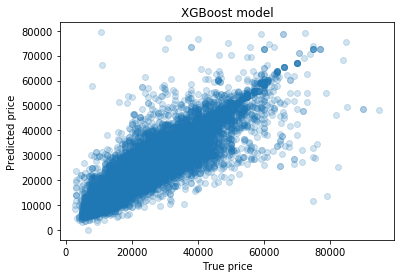

In [37]:
plt.scatter(labels, predictions, alpha=1/5)
plt.xlabel("True price")
plt.ylabel("Predicted price")
plt.title("XGBoost model")
plt.savefig(os.path.join(fig_dir, 'xgboost_pred.jpg'))

In [38]:
from sklearn.metrics import r2_score

score = r2_score(labels, predictions)

print('R-squared score: {}'.format(score))

R-squared score: 0.7832844072803054


In [39]:
distances = np.abs(labels - predictions)

max_distance = np.max(distances)
min_distance = np.min(distances)
mean_distance = np.mean(distances)

print('Min distance: {}'.format(min_distance))
print('Max distance: {}'.format(max_distance))
print('Mean distance: {}'.format(mean_distance))

Min distance: 0.06835940000019036
Max distance: 68591.40625
Mean distance: 3193.5946961869945
